## Setup

In [1]:
import pandas as pd
import logging 
import sys
import os
sys.path.insert(0,'./src')


from src.utils.logger import sys_logger

os.makedirs("./final_data", exist_ok=True)

## Landing Zone to Staging

In [2]:
from src.utils.splitter import split_files

split_files()

[splitter.py:9]                 Files in landing zone: ['products_20241011.json', 'customer_20241009.csv', 'products_20241010.json', 'sales_20241010.txt', 'sales_20241011.txt', 'sales_20241013.txt', 'sales_20241012.txt', 'sales_20241016.txt', 'sales_20241015.txt', 'products_20241016.json', 'sales_20241014.txt', 'products_20241015.json', 'sales_20241009.txt', 'products_20241014.json', 'products_20241009.json', 'customer_20241016.csv', 'customer_20241015.csv', 'products_20241013.json', 'customer_20241014.csv', 'customer_20241010.csv', 'products_20241012.json', 'customer_20241011.csv', 'customer_20241013.csv', 'customer_20241012.csv']
[splitter.py:14]                products_20241011.json matched with product
[splitter.py:17]                products_20241011.json moved to ./data/products/
[splitter.py:14]                customer_20241009.csv matched with customer
[splitter.py:17]                customer_20241009.csv moved to ./data/customer/
[splitter.py:14]                products_202410

## Staging to Tables

In [3]:
from src.utils.ingestion import run_ingestion

run_ingestion()

[watermark.py:8]                Reading watermark table from ./watermark.parquet
[watermark.py:12]               Watermark table not found at ./watermark.parquet. Creating new table
[watermark.py:14]               Watermark table has 0 rows
[ingestion.py:12]               Loading customer data
[watermark.py:18]               Getting last run date for customer
[watermark.py:21]               No previous runs found for customer
[files.py:10]                   Getting files to process from ./data/customer/
[files.py:14]                   Found 8 files to process
[ingestion.py:19]               Processing customer_20241009.csv
[files.py:30]                   Reading csv file from ./data/customer/customer_20241009.csv with kwargs {'sep': ','}
[dataframes.py:134]             Processing data for customer
[files.py:59]                   Getting saved file for customer
[files.py:18]                   Getting save filename for customer
[files.py:38]                   Reading parquet file from ./

## Report Generation

In [4]:
from matplotlib import pyplot as plt

### Customer Growth

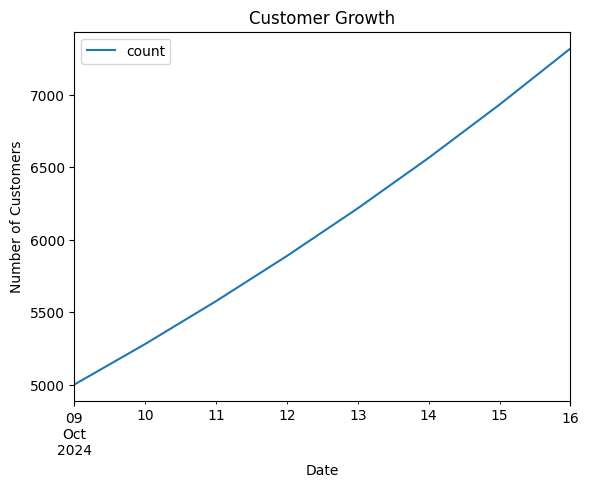

In [5]:
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()

data = []
for date in sorted(dates):
    snapshot = customers[(customers['effective_from'] <= date) & (customers['expiry_date'] > date)]
    data.append({'date': date, 'count': len(snapshot)})

df = pd.DataFrame(data)
df.plot(x='date', y='count')
plt.title('Customer Growth')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.show()

### Sales By Membership

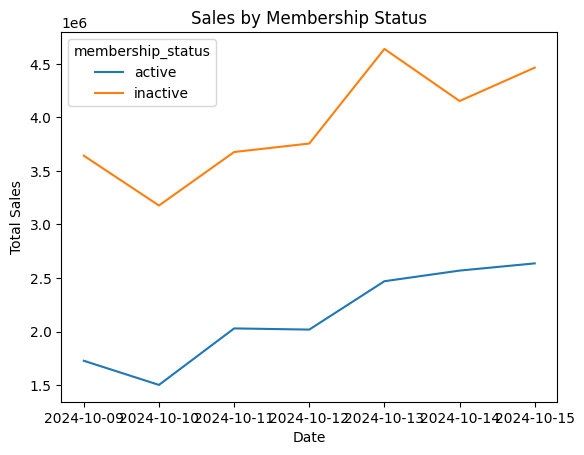

In [6]:
# Sales By Members
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()
sales = pd.read_parquet('./final_data/sales.parquet')
merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
data = merged.groupby(['sale_date', 'membership_status'])['total_price'].sum().unstack().fillna(0)

data.plot()
plt.title('Sales by Membership Status')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

### Product Sale Breakdown

In [7]:
# pivot of most popular products over time from members vs non-members

products = pd.read_parquet('./final_data/product.parquet')
customers = pd.read_parquet('./final_data/customer.parquet')
sales = pd.read_parquet('./final_data/sales.parquet')

merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
merged_with_products = merged.merge(products, on='product_id', how='left')
data = merged_with_products.groupby(['sale_date', 'membership_status', 'name'])['total_price'].sum().unstack().fillna(0)

data

name                              Camera  External Hard Drive  Headphones  \
sale_date  membership_status                                                
2024-10-09 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-10 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-11 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-12 active                   0.00                 0.00   678205.00   
           inactive                 0.00                 0.00  1285350.00   
2024-10-13 active             2550283.20                 0.00   683074.00   
           inactive           4763270.88                 0.00  1316854.00   
2024-10-14 active             2921618.56            215753.46   738180.05   
           inactive           4349880.32            355727.04  1285508.20   
2024-10-15 active             2540523.60            217081.62   696528.00   
           inactive           4409677.60            344829.24  1112832.00   

name                               Laptop     Monitor      Mouse     Printer  \
sale_date  membership_status                                                   
2024-10-09 active              8816292.80  1628895.60  234393.60  1587331.20   
           inactive           18353475.84  3694003.92  549964.80  3383962.40   
2024-10-10 active              6895058.80  1504407.68  206568.72  1303281.44   
           inactive           14974209.60  3291128.64  380302.08  2825822.88   
2024-10-11 active              6783552.00  1350208.00  197869.44  1320954.00   
           inactive           12210393.60  2550598.40  360835.84  2788466.40   
2024-10-12 active              6034572.96  1435310.72  191368.32  1295128.08   
           inactive           11031683.52  2590755.84  345384.00  2427647.76   
2024-10-13 active              4903997.28  1397400.00  173260.80  1460641.60   
           inactive            9626657.04  2472480.00  285880.32  2307418.96   
2024-10-14 active              4675396.00  1194963.84  145403.04  1348475.68   
           inactive            7816340.00  2063854.08  261631.36  2234844.48   
2024-10-15 active              4209469.28  1269053.76  178456.08  1227927.36   
           inactive            7140705.44  1908781.68  264039.76  1948119.36   

name                              Router  Smartphone  Smartwatch     Tablet  
sale_date  membership_status                                                 
2024-10-09 active             1550015.04        0.00        0.00       0.00  
           inactive           3152942.24        0.00        0.00       0.00  
2024-10-10 active             1392053.52        0.00   622643.77       0.00  
           inactive           2513116.32        0.00  1250925.97       0.00  
2024-10-11 active             1268696.32  3496013.82   570077.20       0.00  
           inactive           2266408.96  5925592.92  1166769.45       0.00  
2024-10-12 active             1054041.12  3256309.86   620483.85       0.00  
           inactive           1859568.48  6413658.06  1033328.66       0.00  
2024-10-13 active              952834.24  3059404.32   523596.15       0.00  
           inactive           1750524.00  5815709.76  1120546.35       0.00  
2024-10-14 active              972127.52  3037824.30   496127.94       0.00  
           inactive           1484253.68  4949214.48   923046.81       0.00  
2024-10-15 active              812860.48  2910810.36   451376.38  555688.90  
           inactive           1397803.84  5012801.04   811420.75  980727.28

In [8]:
# 1. The top 10 people who purchased the largest number of products
top_customers = merged.groupby(['customer_id', 'first_name', 'last_name', 'email'])\
                        .agg({'quantity': 'sum'}).reset_index()\
                        .sort_values(by='quantity', ascending=False)\
                        .head(10)
top_customers.rename(columns={'quantity': 'total_items_purchased'}, inplace=True)

top_customers.to_csv('sales_report.csv', index=False)

In [9]:
# 2. The top 10 people who purchased the largest number of products while being an active member
top_active_customers = merged[merged['membership_status'] == 'active']\
                    .groupby(['customer_id', 'first_name', 'last_name', 'email'])\
                    .agg({'quantity': 'sum'}).reset_index()\
                    .sort_values(by='quantity', ascending=False)\
                    .head(10)
top_active_customers.rename(columns={'quantity': 'total_items_purchased'}, inplace=True)

top_active_customers.to_csv('sales_report_active_member.csv', index=False)